# Hyperparameter Tuning with Falkon

## Introduction

We use Falkon for a multi-class problem (on the [digits](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) dataset), showing how to integrate it into scikit-learn
for hyperparameter optimization.

Since both `Falkon` and `LogisticFalkon` are estimators, and follow scikit-learn's API, integration is seamless

In [1]:
%matplotlib inline
from sklearn import datasets, model_selection, metrics
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import falkon

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


## Load the data

We use the **digits** dataset, which is distributed alongside scikit-learn.

In [2]:
X, Y = datasets.load_digits(return_X_y=True)

Label: 1


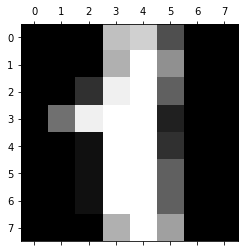

In [3]:
fig, ax = plt.subplots()
_ = ax.matshow(X[1].reshape((8, 8)), cmap='gray')
print("Label: %d" % Y[1])

## Split into training and test sets

We split the data into a training set with 80% of the samples and a test set with the remaining 20%.

In [4]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    X, Y, test_size=0.2, random_state=10, shuffle=True)

## Data Preprocessing

As always with Falkon we must:
 1. Convert from numpy arrays to torch tensors
 2. Convert data and labels to the same data-type (in this case float32)

In [5]:
X_train = torch.from_numpy(X_train).to(dtype=torch.float32)
X_test = torch.from_numpy(X_test).to(dtype=torch.float32)
Y_train = torch.from_numpy(Y_train)
Y_test = torch.from_numpy(Y_test)

Normalizing the data is always a good idea. Here we use the global mean and standard deviation of the training set for z-score normalization.

In [6]:
# z-score normalization
train_mean = X_train.mean()
train_std = X_train.std()
X_train -= train_mean
X_train /= train_std
X_test -= train_mean
X_test /= train_std

Since Falkon optimizes with respect to the square loss, using ordinal labels (e.g. 1, 4, 5) is not ideal since closeness in the natural numbers is meaningless for classification. We therefore convert the labels to a 1-hot representation.

In [7]:
# Convert labels to 1-hot
eye = torch.eye(10, dtype=torch.float32)
Y_train = eye[Y_train]
Y_test = eye[Y_test]
print("First label vector: ", Y_train[0])

First label vector:  tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


## Search for the optimal parameters

Since Falkon (with the Gaussian kernel) has only 3 important hyperparameters, it is entirely feasible to run a grid search over them to find the best parameter settings.

Scikit-learn has great support for this, with the `GridSearchCV` class. For each paramater setting it will run 5-fold cross-validation on the training set, to determine which has the best results.

Given the dataset is quite small, and Falkon is fast, we can run 160 model evaluations in around 40 seconds.

In [8]:
def mclass_loss(true, pred):
    true = torch.argmax(true, dim=1)
    pred = torch.argmax(pred, dim=1)
    return torch.mean((true != pred).to(torch.float32))
mclass_scorer = metrics.make_scorer(mclass_loss, greater_is_better=False)

The parameter settings which will be explored by the grid-search are:
 - four different kernel length-scales (varying around small positive numbers, which are usually good for normalized data)
 - four different regularization values
 - two different values for M: the number of inducing points. As we will see, a larger `M` is almost always better than a smaller one (but it leads to longer training times). 
   Of course this is not the case if the dataset is easy to overfit, since reducing `M` may also provide additional regularization.

When we create the estimator we pass it additional parameters via the `FalkonOptions` class.
In our case we want to ensure that the model runs on the CPU by setting `use_cpu=True`.

In [9]:
parameter_grid = {
    'kernel': [falkon.kernels.GaussianKernel(sigma=1), 
               falkon.kernels.GaussianKernel(sigma=5), 
               falkon.kernels.GaussianKernel(sigma=10),
               falkon.kernels.GaussianKernel(sigma=15),],
    'penalty': [1e-3, 1e-5, 1e-7, 1e-9],
    'M': [500, 1000],
}
estimator = falkon.Falkon(
    kernel=falkon.kernels.GaussianKernel(1), penalty=1e-3, M=1000,  # Mandatory parameters, will be overridden
    maxiter=10, options=falkon.FalkonOptions(use_cpu=True))

grid_search = model_selection.GridSearchCV(estimator, parameter_grid, scoring=mclass_scorer, cv=5)

In [10]:
%%time
grid_search.fit(X_train, Y_train)
print("The best parameters are: ", grid_search.best_params_)

The best parameters are:  {'M': 500, 'kernel': GaussianKernel(sigma=Parameter containing:
tensor([10.], dtype=torch.float64)), 'penalty': 1e-07}
CPU times: user 52.3 s, sys: 1.78 s, total: 54.1 s
Wall time: 13.6 s


### Evaluating the model
We evaluate the model on the held-out set and see that we obtain a respectable 1% error on 10 classes.

In [11]:
%%time
flk = grid_search.best_estimator_
flk.fit(X_train, Y_train)
test_pred = flk.predict(X_test)
train_pred = flk.predict(X_train)

CPU times: user 534 ms, sys: 23.8 ms, total: 558 ms
Wall time: 139 ms


In [12]:
print("Training error: %.2f%%" % (mclass_loss(Y_train, train_pred) * 100))
print("Test error: %.2f%%" % (mclass_loss(Y_test, test_pred) * 100))

Training error: 0.00%
Test error: 1.11%


## Plot grid-search results

Plotting results from a grid-search is always useful, since it shows the range of parameters which were successful.
If the initial grid was too coarse, one could then run a second grid search to obtain even better accuracy.

In the plot red indicates a high error, while darker blue indicates a low error.

In [13]:
res_df = pd.DataFrame.from_dict(grid_search.cv_results_)
res_df["M"] = res_df.params.apply(lambda x: x.get("M"))
res_df["penalty"] = res_df.params.apply(lambda x: x.get("penalty"))
res_df["sigma"] = res_df.params.apply(lambda x: x.get("kernel").sigma.item())
res_df = res_df[["mean_test_score", "M", "penalty", "sigma"]]

In [14]:
def plot_heatmap(ax, df, xlabel, ylabel, value, scale):
    piv = pd.pivot_table(df, index=ylabel, columns=xlabel, values=value)
    cmap = plt.cm.get_cmap('coolwarm_r', 20)
    ax.grid(False)
    c = ax.pcolormesh(piv, cmap=cmap, vmin=scale[0], vmax=scale[1])
    ax.set_yticks(np.arange(piv.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(piv.shape[1]) + 0.5, minor=False)
    ax.set_xticklabels(piv.columns, minor=False)
    ax.set_yticklabels(piv.index, minor=False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return c

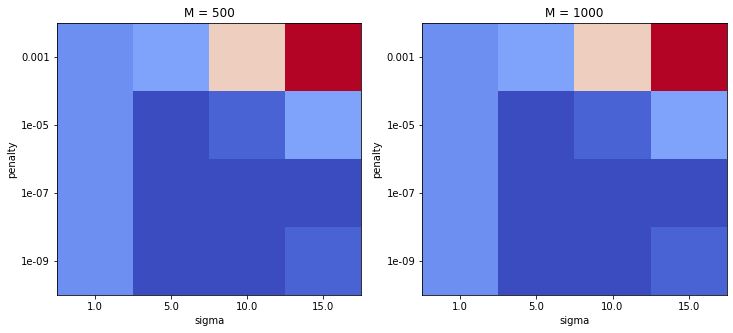

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
scale = (res_df["mean_test_score"].min(), res_df["mean_test_score"].max())

c = plot_heatmap(axs[0], res_df[res_df.M == 500], "sigma", "penalty", "mean_test_score", scale)
axs[0].set_title("M = 500")
c = plot_heatmap(axs[1], res_df[res_df.M == 1000], "sigma", "penalty", "mean_test_score", scale)
_ = axs[1].set_title("M = 1000")